## Лекция 8.
# Способы улучшения полученной модели.

* [Теоретическая часть](#theory)
    * [Переобучение и способы борьбы с ним](#overfitting)
    * [Регуляризация](#regularization)
    * [Заполнение пропусков/выбросов](#imputer)
* [Практическая часть](#practice)
    * [LogisticRegression](#lr)
    * [Support Vector Machine](#svm)
    * [XGBoost](#xgb)
    * [CatBoost](#cat)
        * [Модель, полученная на предыдущем уроке](#model_from_prev_lesson)
        * [Снижение степени переобучения](#lowering_overfitting)
        * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
        * [Выбор порога вероятности для определения класса](#threshold_calibration)
        * [Важность признаков](#feature_importances)  
        * [Финальная модель](#final_model)
        * [Сохранение финальной модели](#final_model_saving)
* [Обобщение работы с новой задачей](#summary)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

### Переобучение и способы борьбы с ним<a class="anchor" id="overfitting"></a>

**Переобучение**

Нежелательное явление, возникающее при решении задач обучения по прецедентам, когда вероятность ошибки обученного алгоритма на объектах тестовой выборки оказывается существенно выше, чем средняя ошибка на обучающей выборке. Переобучение возникает при использовании избыточно сложных моделей.

overfitting.svg

**Способы борьбы с переобучением**

1. Обнаружить переобучение:
    * отложенная выборка
    * кросс-валидация
    * меры сложности модели
2. Взять больше данных
3. Взять меньше признаков
4. Выбрать более простую модель
5. Регуляризация

### Регуляризация<a class="anchor" id="regularization"></a>

Метод регуляризации заключается в "штрафовании" модели за слишком большие веса путем добавления нового члена к ошибке:

$$Q(w, X) + \lambda ||w||^{2} \rightarrow \underset{w}{\text{min}}.$$

добавленный член $\lambda ||w||^{2}$ - **квадратичный регуляризатор**, который представляет собой $L_{2}$-норму вектора весов, то есть сумму квадратов весов $\sum^{d}_{j=1}w_{j}^{2}$, коэффициент $\lambda$ при нем - коэффициент регуляризации.

Чем больше его $\lambda$, тем меньшая сложность модели будет получаться в процессе такого обучения.

    - Если увеличивать его, в какой-то момент оптимальным для модели окажется зануление всех весов
    - А при слишком низких его значениях появляется вероятность чрезмерного усложнения модели и переобучения
    - Подбираем по кросс-валидации

По сути, смысл регуляризации заключается в минимизации функционала ошибки с ограничением весов.

$$\begin{cases} Q(w, X) \rightarrow min \\ ||w||^2 \leq C \end{cases}$$

**L1-регуляризация** (lasso, регуляризация через манхэттенское расстояние)

$\large L_1 = \sum_{i=1} |(y_i - \widehat{y_i})| + \lambda\sum_{j=1} |w_j|$

**L2-регуляризация** (ridge, регуляризация Тихонова)

$\large L_2 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} w_j^2$

## <center>Практическая часть<a class="anchor" id="practice"></a><center>

**Подключение библиотек и скриптов**

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import output
output.enable_custom_widget_manager()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)

    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns,
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring='f1',
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize = (20, len(feature_importances) * 0.355))

    sns.barplot(feature_importances['importance']) #, feature_importances['feature']])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [9]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)

    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

**Пути к директориям и файлам**

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
# DATA_ROOT = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_data.csv'
# MODELS_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/'

# input
DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_data.csv'
PREP_DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_train_full.csv'
TRAIN_PART_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_train_part_b.csv'
TEST_PART_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/training_project_test_part.csv'

SCALER_FILE_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/scaler.pkl'
MODEL_FILE_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_8/data/training_project/model.pkl'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [76]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [77]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                      'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                      'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [78]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_test = df_test[TARGET_NAME]

In [79]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')

df_balanced[TARGET_NAME].value_counts()

0    5464
1    4608
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [80]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Заполнение пропусков/выбросов<a class='anchor' id='imputer'>

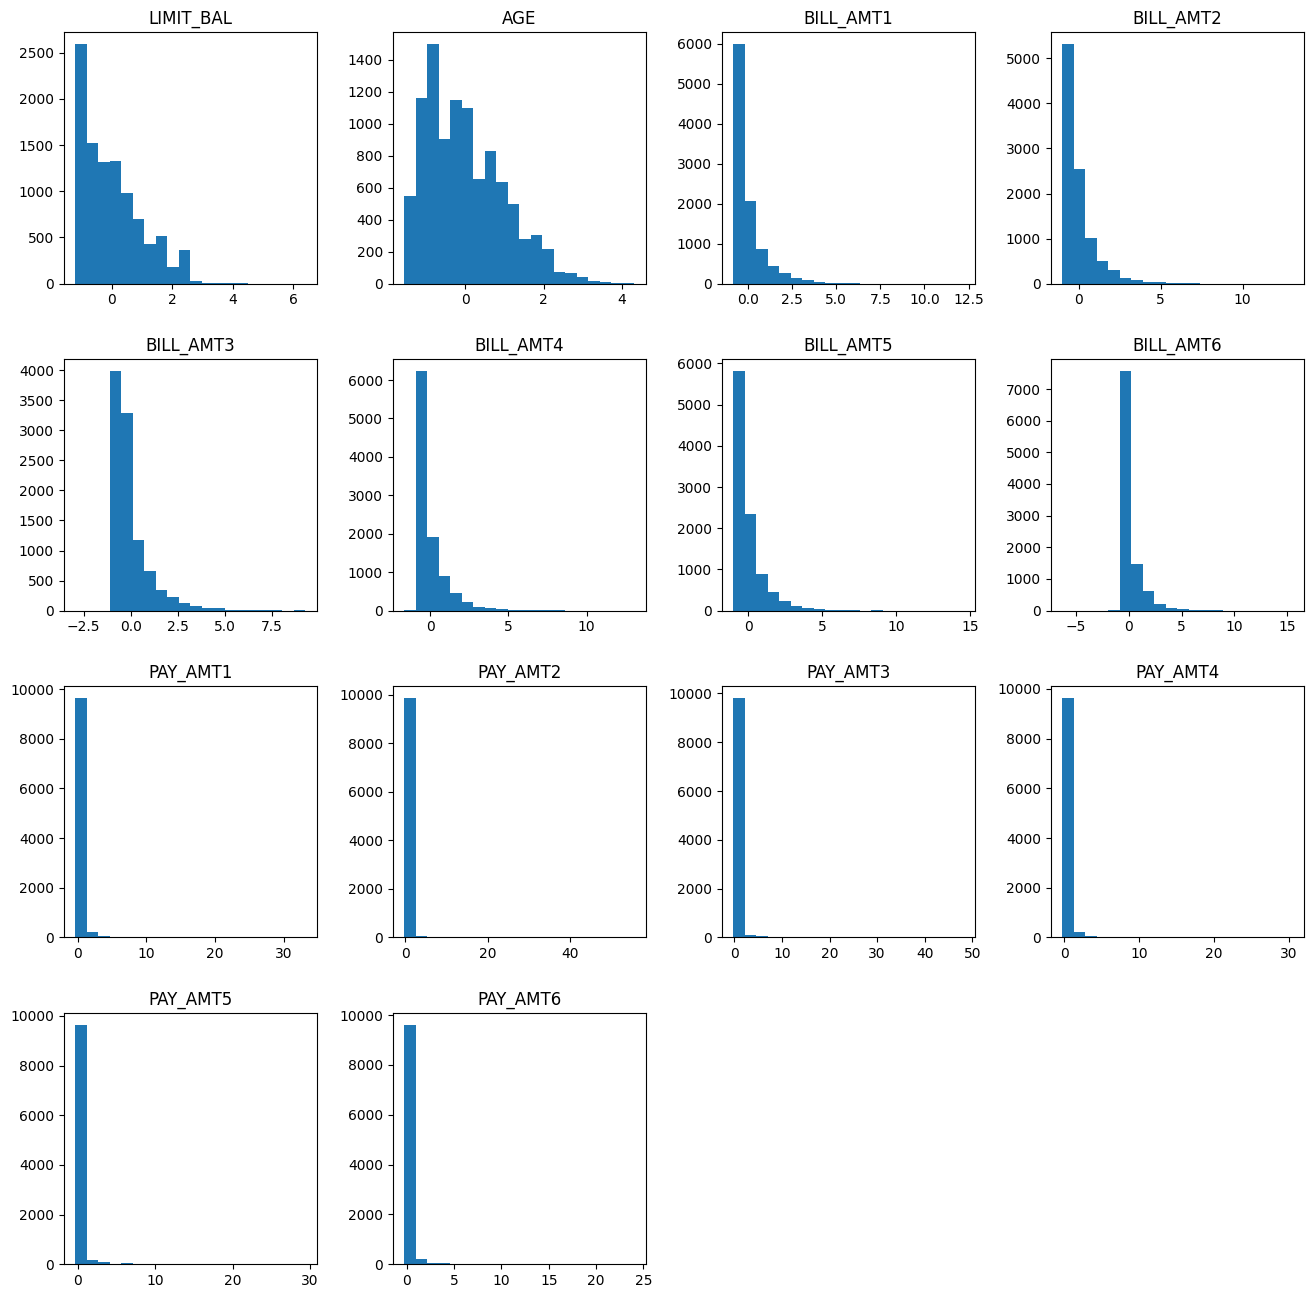

In [81]:
df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()

    features = data.columns

    data = data[features]

    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=2)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [83]:
df_copy = df.copy()
df_test_copy = df_test.copy()

In [84]:
df_copy.isna().sum().sum()

0

**BILL_AMT_1**

In [85]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'BILL_AMT1'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

56

In [86]:
%%time
bill_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [87]:
df_copy[feature_name].isna().sum()

0

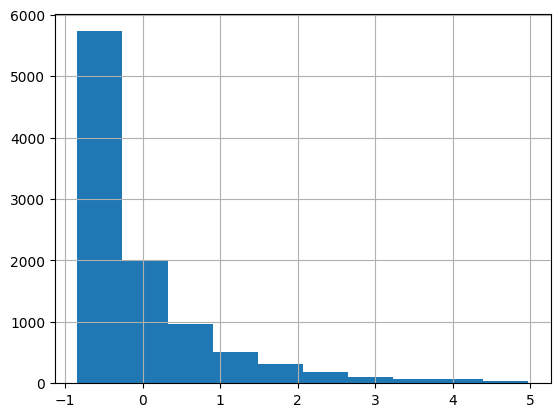

In [88]:
df_copy[feature_name].hist();

**PAY_AMT1**

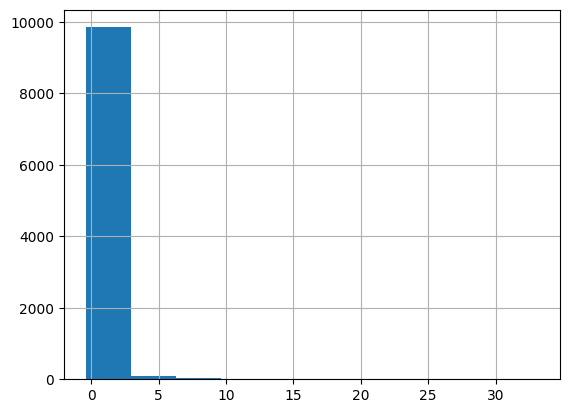

In [25]:
feature_name = 'PAY_AMT1'
df_copy[feature_name].hist();

In [26]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

68

In [27]:
pay_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s


r2 на train: 0.9170161684362456
r2 на test: 0.7456465762909973


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [28]:
df_copy[feature_name].isna().sum()

0

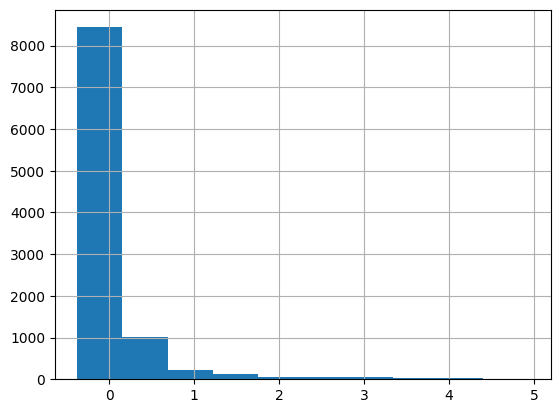

In [29]:
df_copy[feature_name].hist();

## Logistic Regression <a class='anchor' id='lr'>

In [30]:
model_lr = LogisticRegression(C=0.8,
                              max_iter=100
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.86      0.76      5464
           1       0.77      0.54      0.63      4608

    accuracy                           0.71     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.72      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2341
           1       0.54      0.51      0.53       659

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.70      3000
weighted avg       0.79      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2061  280
1                    324  335


(array([-0.1806491]), -0.027528245651603018)

In [31]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [32]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=100,
                                   cv=cv, Cs=[0.1, 1, 10, 100, 1000],
                                   )
model_lr_cv.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.86      0.77      5464
           1       0.77      0.54      0.63      4608

    accuracy                           0.71     10072
   macro avg       0.73      0.70      0.70     10072
weighted avg       0.73      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2341
           1       0.55      0.51      0.53       659

    accuracy                           0.80      3000
   macro avg       0.71      0.69      0.70      3000
weighted avg       0.79      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2065  276
1                    326  333
CPU times: user 2.54 s, sys: 1.46 s, total: 4 s
Wall time: 2.15 s


In [33]:
model_lr_cv.Cs_

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [34]:
model_lr_cv.C_

array([0.1])

## Support Vector Machine <a class='anchor' id='svm'>

In [35]:
%%time
model_svc = SVC(C=0.1,
                kernel='rbf'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.89      0.77      5464
           1       0.80      0.50      0.61      4608

    accuracy                           0.71     10072
   macro avg       0.74      0.70      0.69     10072
weighted avg       0.73      0.71      0.70     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2341
           1       0.59      0.47      0.52       659

    accuracy                           0.81      3000
   macro avg       0.72      0.69      0.70      3000
weighted avg       0.80      0.81      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2124  217
1                    352  307
CPU times: user 14.5 s, sys: 135 ms, total: 14.6 s
Wall time: 14.7 s


In [89]:
%%time
model_svc = SVC(C=1,
                kernel='poly',
                degree=8
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.98      0.77      5464
           1       0.93      0.32      0.48      4608

    accuracy                           0.68     10072
   macro avg       0.78      0.65      0.62     10072
weighted avg       0.77      0.68      0.64     10072

TEST

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2341
           1       0.49      0.16      0.24       659

    accuracy                           0.78      3000
   macro avg       0.64      0.56      0.55      3000
weighted avg       0.73      0.78      0.73      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2233  108
1                    556  103
CPU times: user 34.8 s, sys: 176 ms, total: 35 s
Wall time: 42 s


## XGBoost<a class='anchor' id='xgb'>

In [90]:
model_xgb = xgb.XGBClassifier(random_state=21,
                              max_depth=2,
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      5464
           1       0.78      0.64      0.70      4608

    accuracy                           0.75     10072
   macro avg       0.76      0.74      0.75     10072
weighted avg       0.76      0.75      0.75     10072

TEST

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2341
           1       0.51      0.57      0.54       659

    accuracy                           0.79      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.79      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1988  353
1                    285  374


In [94]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10],
    'n_estimators': [5, 15, 20, 30, 45],
    # 'min_sample_leaf: []'
}

In [95]:
cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [96]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=1, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'n_estimators': 45, 'reg_lambda': 0.2}

0.6716332192018416

CPU times: user 42.6 s, sys: 113 ms, total: 42.7 s
Wall time: 26 s


In [100]:
model_xgb = xgb.XGBClassifier(random_state=21,
                              max_depth=2,
                              reg_lambda=0.2,
                              n_estimators = 45
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      5464
           1       0.77      0.60      0.68      4608

    accuracy                           0.74     10072
   macro avg       0.75      0.73      0.73     10072
weighted avg       0.74      0.74      0.73     10072

TEST

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2341
           1       0.53      0.57      0.55       659

    accuracy                           0.79      3000
   macro avg       0.70      0.71      0.71      3000
weighted avg       0.80      0.79      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2005  336
1                    286  373


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [101]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring='f1',
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 

In [102]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

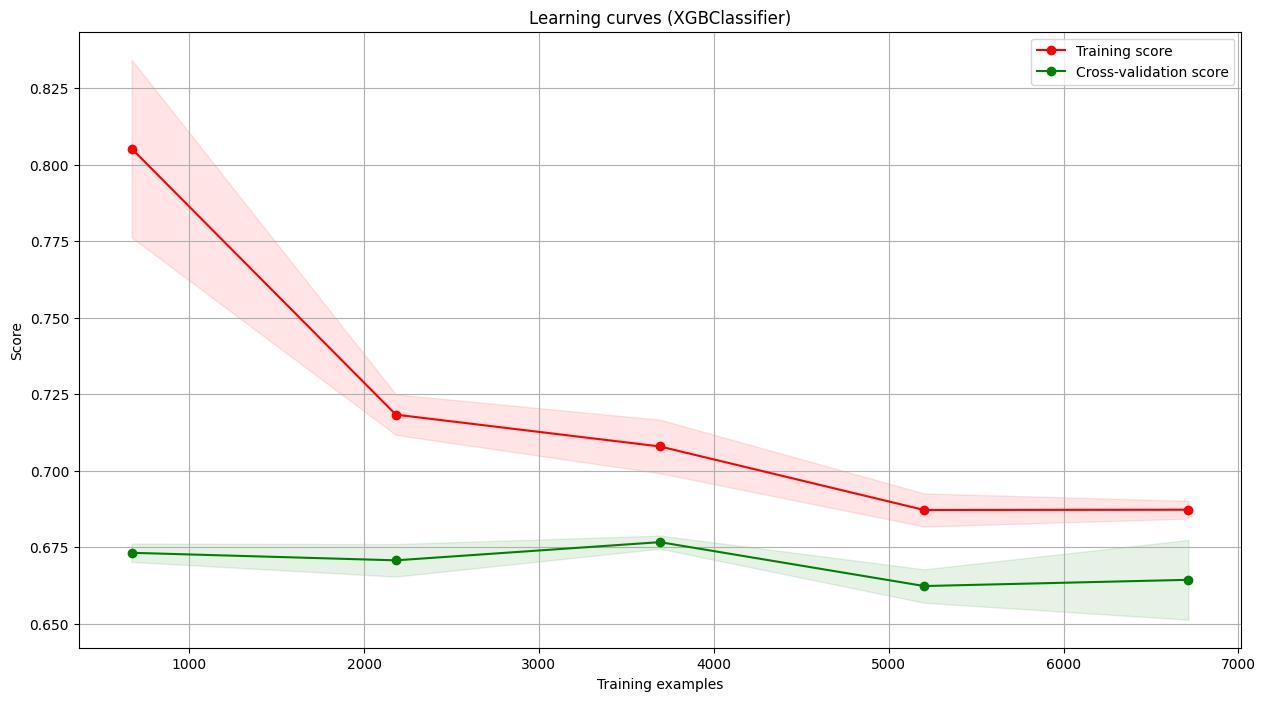

In [103]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [104]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.6012489 , 0.39875108],
       [0.7571672 , 0.24283275],
       [0.48386943, 0.51613057],
       ...,
       [0.73172325, 0.26827675],
       [0.20646417, 0.7935358 ],
       [0.5681608 , 0.43183923]], dtype=float32)

In [105]:
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)

    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label=

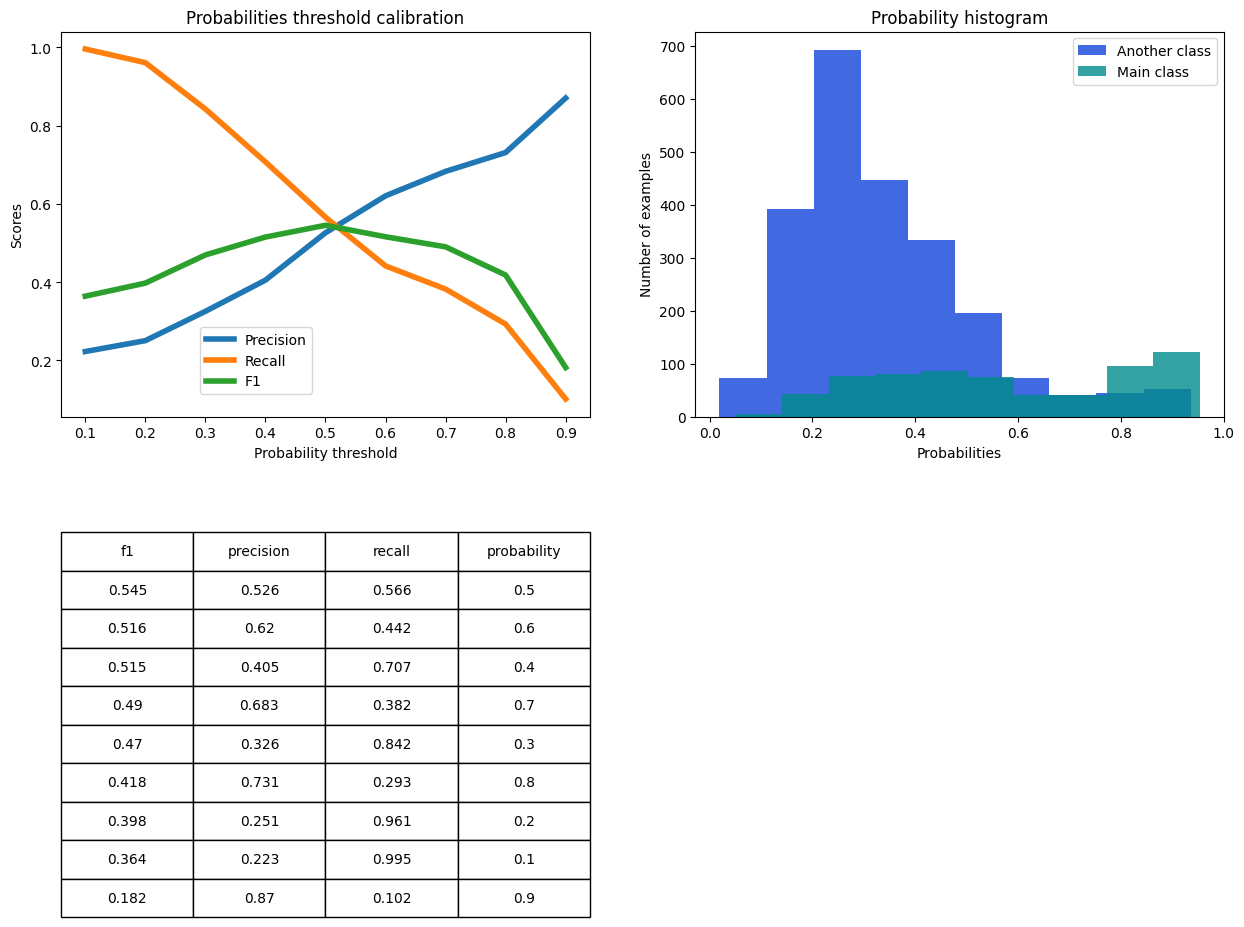

In [106]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

In [107]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize = (20, len(feature_importances) * 0.355))

    sns.barplot(data=None, x=feature_importances['importance'], y=feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



In [108]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize = (20, len(feature_importances) * 0.355))

    sns.barplot(data=None, x=feature_importances['importance'], y=feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

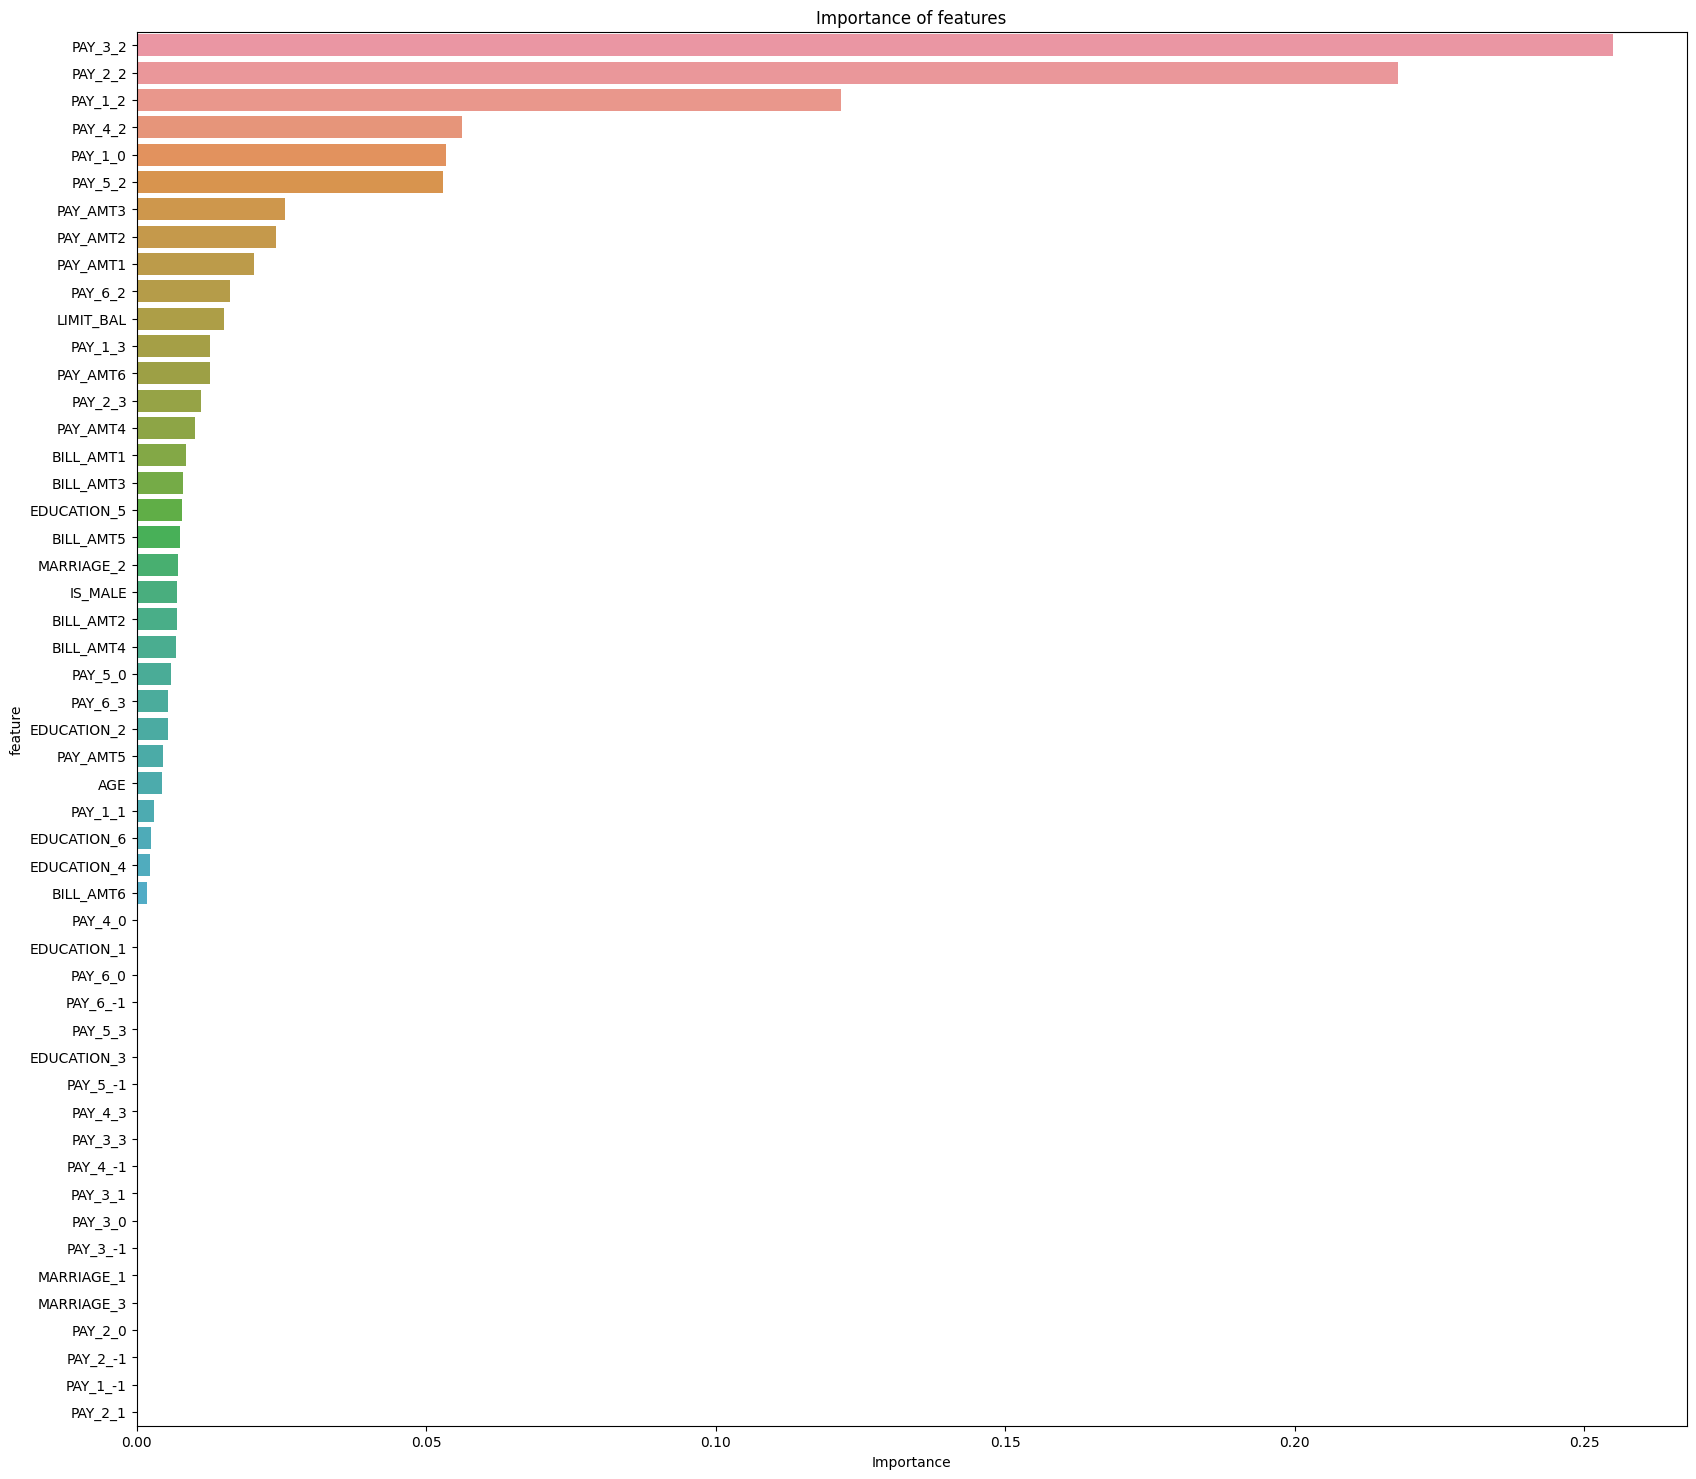

In [112]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=30)

In [113]:
important_features_top

['PAY_3_2',
 'PAY_2_2',
 'PAY_1_2',
 'PAY_4_2',
 'PAY_1_0',
 'PAY_5_2',
 'PAY_AMT3',
 'PAY_AMT2',
 'PAY_AMT1',
 'PAY_6_2',
 'LIMIT_BAL',
 'PAY_1_3',
 'PAY_AMT6',
 'PAY_2_3',
 'PAY_AMT4',
 'BILL_AMT1',
 'BILL_AMT3',
 'EDUCATION_5',
 'BILL_AMT5',
 'MARRIAGE_2',
 'IS_MALE',
 'BILL_AMT2',
 'BILL_AMT4',
 'PAY_5_0',
 'PAY_6_3',
 'EDUCATION_2',
 'PAY_AMT5',
 'AGE',
 'PAY_1_1',
 'EDUCATION_6']

### Финальная модель<a class="anchor" id="final_model"></a>

In [119]:
final_xgb = xgb.XGBClassifier(random_state=21,
                              max_depth=1,
                              reg_lambda=0.2,
                              n_estimators = 45
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      5464
           1       0.79      0.53      0.63      4608

    accuracy                           0.72     10072
   macro avg       0.74      0.70      0.70     10072
weighted avg       0.73      0.72      0.71     10072

TEST

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2341
           1       0.57      0.50      0.53       659

    accuracy                           0.81      3000
   macro avg       0.72      0.70      0.71      3000
weighted avg       0.80      0.81      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2092  249
1                    328  331


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [115]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_xgb, file)

## Catboost<a class='anchor' id='cat'>

In [120]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train = df_train[BASE_FEATURE_NAMES]
y_train = df_train[TARGET_NAME]

X_test = df_test[BASE_FEATURE_NAMES]
y_test = df_test[TARGET_NAME]

### Модель, полученная на предыдущей лекции<a class="anchor" id="model_from_prev_lesson"></a>

In [121]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

3.5572916666666665

In [56]:
frozen_params = {
     'class_weights':[1, disbalance],
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [122]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=3)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      5464
           1       0.49      0.67      0.56      1536

    accuracy                           0.77      7000
   macro avg       0.69      0.73      0.70      7000
weighted avg       0.81      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2341
           1       0.49      0.63      0.55       659

    accuracy                           0.77      3000
   macro avg       0.69      0.72      0.70      3000
weighted avg       0.80      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1908  433
1                    246  413
CPU times: user 4.54 s, sys: 272 ms, total: 4.81 s
Wall time: 3.45 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [127]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=3,
                                # l2_leaf_reg=5,
                                reg_lambda=0.2
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.82      0.84      5464
           1       0.47      0.59      0.52      1536

    accuracy                           0.77      7000
   macro avg       0.67      0.70      0.68      7000
weighted avg       0.79      0.77      0.77      7000

TEST

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2341
           1       0.48      0.57      0.52       659

    accuracy                           0.77      3000
   macro avg       0.68      0.70      0.69      3000
weighted avg       0.79      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1940  401
1                    283  376


In [130]:
params = {
    'reg_lambda': np.linspace(0.1, 10, 80)
}

In [129]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [128]:
cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [131]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6739005703
bestIteration = 44

0:	loss: 0.6739006	best: 0.6739006 (0)	total: 2.1s	remaining: 1m 43s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6637598862
bestIteration = 50

1:	loss: 0.6637599	best: 0.6739006 (0)	total: 4.94s	remaining: 1m 58s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6593833836
bestIteration = 33

2:	loss: 0.6593834	best: 0.6739006 (0)	total: 6.99s	remaining: 1m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.664375928
bestIteration = 56

3:	loss: 0.6643759	best: 0.6739006 (0)	total: 9.5s	remaining: 1m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6839710275
bestIteration = 130

4:	loss: 0.6839710	best: 0.6839710 (4)	total: 14.9s	remaining: 2m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6664340978
bestIteration = 59

5:	loss: 0.6664341	best: 0.6839710 (4)	total: 17.7s	remain

In [132]:
grid_search

{'params': {'l2_leaf_reg': 8.245569620253164},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
    

In [133]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5464
           1       0.51      0.67      0.58      1536

    accuracy                           0.79      7000
   macro avg       0.70      0.75      0.72      7000
weighted avg       0.81      0.79      0.80      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2341
           1       0.49      0.60      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.78      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1938  403
1                    265  394
CPU times: user 102 ms, sys: 2.89 ms, total: 105 ms
Wall time: 99.2 ms


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

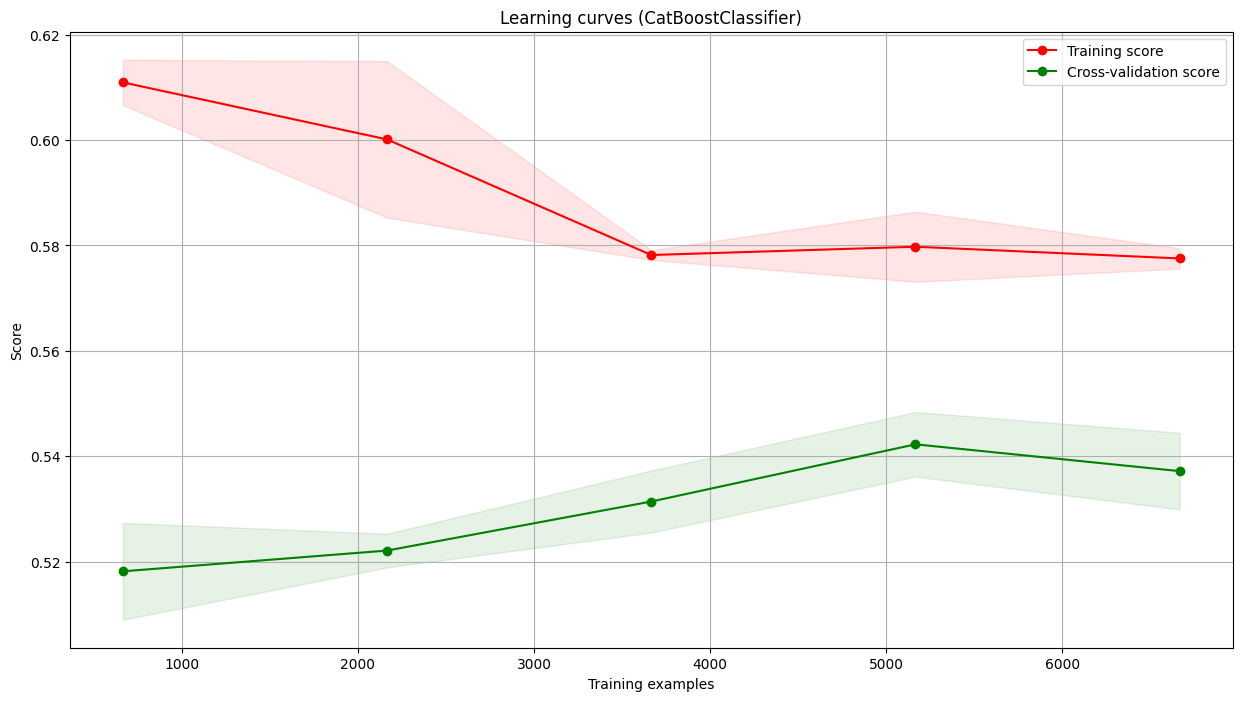

In [134]:
show_learning_curve_plot(model_catb, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

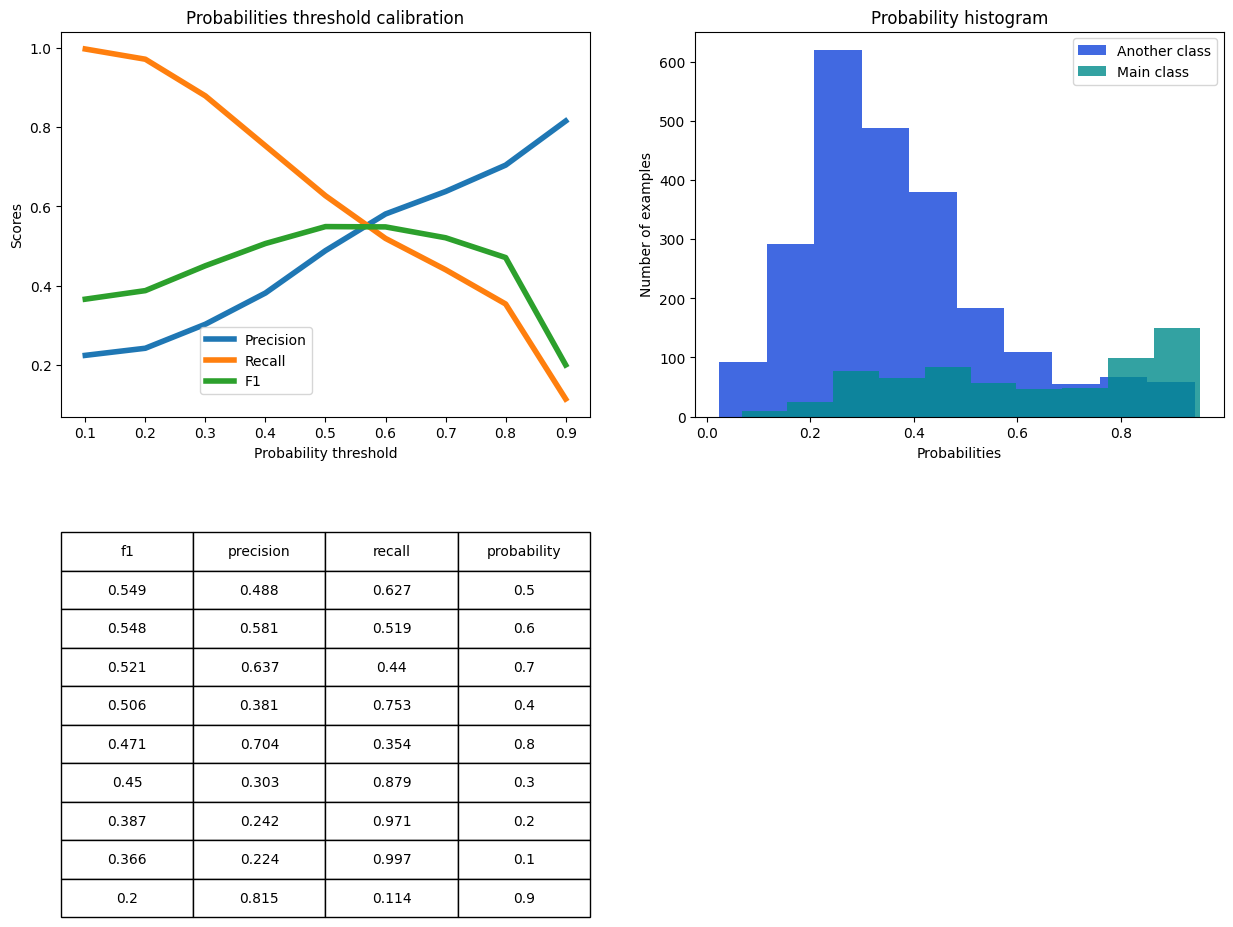

In [135]:
y_test_pred_probs = model_catb.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

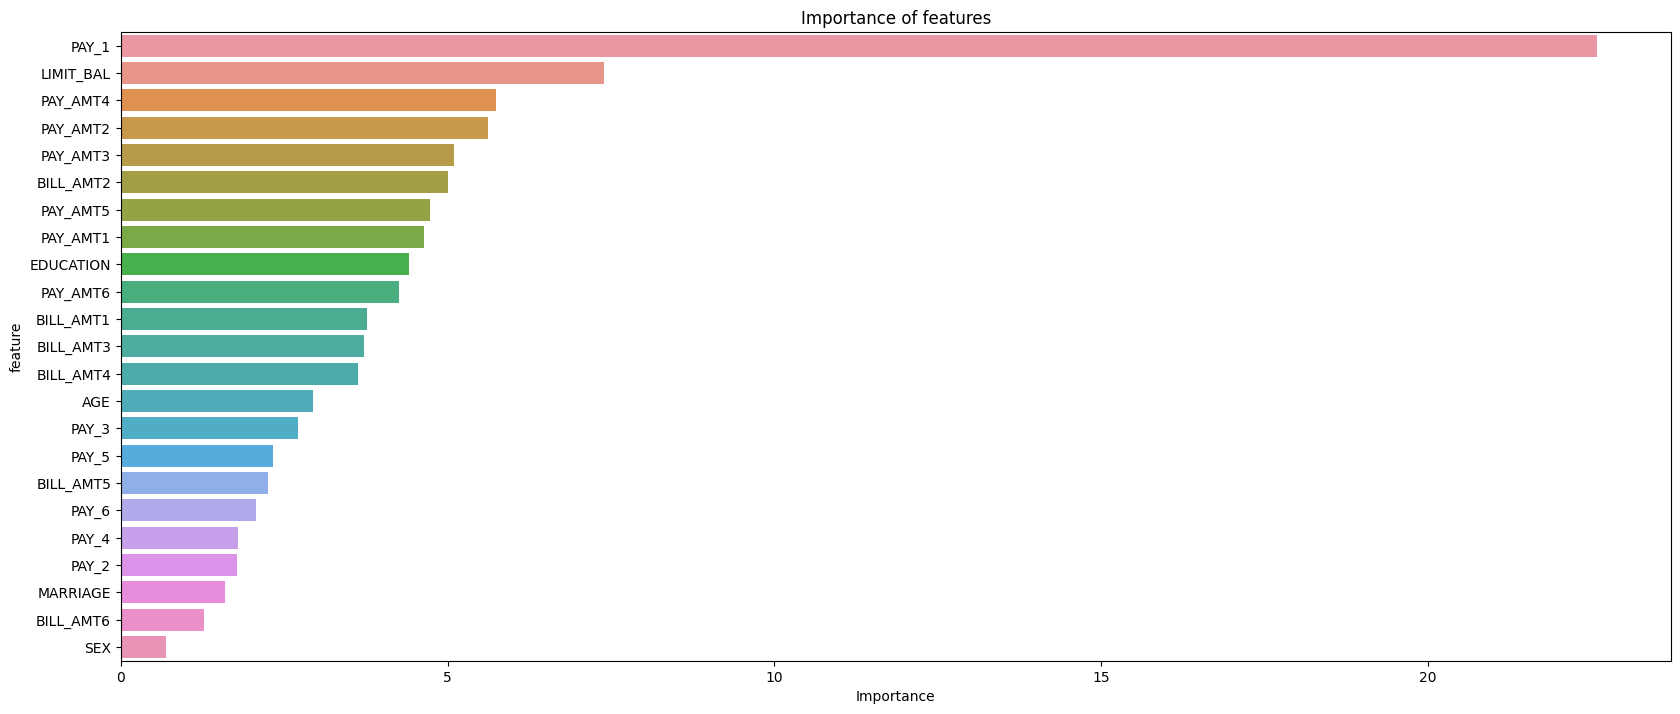

In [136]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=20)

In [68]:
important_features_top

['PAY_1',
 'LIMIT_BAL',
 'PAY_AMT2',
 'EDUCATION',
 'PAY_AMT1',
 'PAY_2',
 'PAY_AMT3',
 'BILL_AMT1',
 'BILL_AMT2',
 'PAY_AMT4',
 'PAY_AMT6',
 'PAY_AMT5',
 'PAY_4',
 'PAY_5',
 'BILL_AMT4',
 'AGE',
 'PAY_3',
 'MARRIAGE',
 'BILL_AMT6',
 'BILL_AMT3']

### Финальная модель<a class="anchor" id="final_model"></a>

In [138]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))

In [140]:
%%time

frozen_params = {
     'class_weights':[1, disbalance],
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=2,
                                      reg_lambda=8.245569620253164)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5464
           1       0.48      0.59      0.53      1536

    accuracy                           0.77      7000
   macro avg       0.68      0.71      0.69      7000
weighted avg       0.79      0.77      0.78      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2341
           1       0.50      0.58      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.79      0.78      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1963  378
1                    278  381
CPU times: user 4.21 s, sys: 370 ms, total: 4.58 s
Wall time: 4.99 s


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [71]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Необходимые требования для выполнения задачи

* F1-score > 0.5
* F1-score_1, recall_1, precision_1 > 0.5
* Оценка и интерпретация полученной модели.
_____________

### Обобщение работы с заданием <a class='anchor' id='summary'>
**1. Получить базовое решение**

    * Минимально познакомиться с данными
    * Заполнить пропуски простым методом (нулями, медиана, среднее, мода...)
    * Обучить простую модель (линейная, деревья...)
    * Посчитать метрику качества

**2. EDA**

    * Изучить целевую переменную
        * регрессия - распределение, меры центральной тенденции
        * классификация - баланс классов
    * Изучить признаки
        * корреляция
        * найти проблемные признаки
        * найти пропуски
        * найти выбросы
        * сгенерировать идеи по их заполнению
    * Изучить влияние признаков на целевую переменную
        * корреляция
        * классификация - разделение значений в зависимости от классов

**3. Предобработка данных**

    * Разделить данные на train и test
    * Зависит от выбранной модели
        * Масштабирование
    * Заполнить пропуски
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Обработать выбросы
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Генерация новых признаков
        1. Категориальные признаки
            a. pd.get_dummies, OneHotEncoder
            b. Feature Encoding
            c. Target Encoding
        2. Вещественные признаки
            a. Feature discretization
            b. Feature binarization
    * Оформить предобработку в класс/функции для воспроизводимости

**4. Обучение и валидация моделей**

    * Обучить модель на базовых гиперпараметрах
    * Вручную настраивать гиперпарметры
    * Автоматизированный выбор гиперпараметров с кросс-валидацией GridSearchCV/RandomSearchCV
    * Следить за переобучением, если оно появляется, то искать лучший параматер регуляризации
    * Посчитать метрики

**5. Воспроизводимость**

    * Зафиксировать результаты эксперимента
    * Сохранить модели